## Ferature Engineering

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import multiprocessing as mp
import gc
import datetime
from sklearn.preprocessing import LabelEncoder
import calendar
from scipy.sparse import csr_matrix,hstack
#import tensorflow as tf
from sklearn.linear_model import LinearRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import mean_squared_error
from lightgbm import LGBMRegressor
from tqdm import tqdm
import pickle

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train=pd.read_csv('/content/drive/MyDrive/train.csv')
test=pd.read_csv('/content/drive/MyDrive/test.csv')
final_test=pd.read_csv('/content/drive/MyDrive/final_test.csv')
cv=pd.read_csv('/content/drive/MyDrive/cv.csv')

In [ ]:
%%time
#Firstly we will create these Direct features for train  and CV test and final test data
# Code to create one large data for all days
gc.collect()
tt=pd.concat([train,cv,test,final_test])
tt.sort_values(['id','date'],inplace=True)
df=tt.pivot_table(index=['item_id','store_id'],columns='date',values='sales')
df.fillna(0,inplace=True)

CPU times: user 1min 19s, sys: 18.1 s, total: 1min 38s
Wall time: 1min 37s


In [ ]:
%%time
#this code snippet is used to calculate rolling mean and rolling std of sales data with shift of 28 days 
# Here we are taking 28 days shift so as to avoid Data Leakage Problem
for aggregate in ['mean','std']:
    for shif in [28]:
        for r in [7,14,30,60,360]:
            roll=df.rolling(r,axis=1).agg(aggregate).shift(shif)
            dates=roll.columns
            name="roll_"+str(r)+"_shift_"+str(shif)+"_"+aggregate
            roll=roll.astype('float16')
            roll.reset_index(level=[0,1],inplace=True)
            roll=pd.melt(roll,id_vars=['item_id','store_id'],value_vars=dates,var_name='date',value_name=name)
            roll.fillna(-1,inplace=True)
            train=train.merge(roll,on=['item_id','store_id','date'])
            cv=cv.merge(roll,on=['item_id','store_id','date'])
            final_test=final_test.merge(roll,on=['item_id','store_id','date'])
            test=test.merge(roll,on=['item_id','store_id','date'])
            print("Feature created named :=",name)
            del roll
            gc.collect()

Feature created named := roll_7_shift_28_mean
Feature created named := roll_14_shift_28_mean
Feature created named := roll_30_shift_28_mean
Feature created named := roll_60_shift_28_mean
Feature created named := roll_360_shift_28_mean
Feature created named := roll_7_shift_28_std
Feature created named := roll_14_shift_28_std
Feature created named := roll_30_shift_28_std
Feature created named := roll_60_shift_28_std
Feature created named := roll_360_shift_28_std
CPU times: user 13min 45s, sys: 2min 37s, total: 16min 23s
Wall time: 16min 14s


In [ ]:
# Adding  Exponential weighted average with shift of 28 days
# Shift of 28 days is used to prevent data leakage Problem
roll=df.shift(28,axis=1).ewm(alpha=0.99,axis=1,adjust=False).mean()
dates=roll.columns
roll=roll.astype('float16')
roll.reset_index(level=[0,1],inplace=True)
roll=pd.melt(roll,id_vars=['item_id','store_id'],value_vars=dates,var_name='date',value_name='direct_ewm')
roll.fillna(-1,inplace=True)
train=train.merge(roll,on=['item_id','store_id','date'])
cv=cv.merge(roll,on=['item_id','store_id','date'])
test=test.merge(roll,on=['item_id','store_id','date'])
final_test=final_test.merge(roll,on=['item_id','store_id','date'])
print("Direct Feature created ewa window of size")

Direct Feature created ewa window of size


In [ ]:
%%time
# Now we will also calculate lag features with lag of 28,35,42,49,56,63,70,77,84,91,96 days
for lag in range(28,100,7):
    i='direct_lag_'+str(lag)
    lag_i=df.shift(lag,axis=1)
    dates=lag_i.columns
    lag_i.reset_index(level=[0,1],inplace=True)
    lag_i=pd.melt(lag_i,id_vars=['item_id','store_id'],value_vars=dates,var_name='date',value_name=i)
    lag_i.fillna(-1,inplace=True)
    lag_i[i]=lag_i[i].astype('int16')
    train=train.merge(lag_i,on=['item_id','store_id','date'])
    cv=cv.merge(lag_i,on=['item_id','store_id','date'])
    test=test.merge(lag_i,on=['item_id','store_id','date'])
    final_test=final_test.merge(lag_i,on=['item_id','store_id','date'])
    print("Feature created for lag",lag)
    del lag_i
    gc.collect()

Feature created for lag 28
Feature created for lag 35
Feature created for lag 42
Feature created for lag 49
Feature created for lag 56
Feature created for lag 63
Feature created for lag 70
Feature created for lag 77
Feature created for lag 84
Feature created for lag 91


<timed exec>:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


Feature created for lag 98
CPU times: user 14min 10s, sys: 2min 50s, total: 17min 1s
Wall time: 16min 52s


In [ ]:
%%time
train.to_csv('train1.csv',index=False)
cv.to_csv('cv1.csv',index=False)
test.to_csv('test1.csv',index=False)
final_test.to_csv('final_test1.csv',index=False)

CPU times: user 9min 42s, sys: 11.6 s, total: 9min 54s
Wall time: 9min 52s


## Modeling

In [ ]:
#Importing Required Libraries
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
import dask.dataframe as dk
import calendar
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler,Normalizer
from xgboost import XGBRegressor
from scipy.sparse import csr_matrix,hstack
from sklearn.feature_extraction.text import CountVectorizer
import tensorflow as tf
from sklearn.linear_model import SGDRegressor
from lightgbm import LGBMRegressor
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
#from catboost import CatBoostRegressor
#import catboost as cat
from sklearn.ensemble import AdaBoostRegressor
import pickle

In [ ]:
train=pd.read_csv('/content/drive/MyDrive/train1.csv')
test=pd.read_csv('/content/drive/MyDrive/test1.csv')
final_test=pd.read_csv('/content/drive/MyDrive/final_test1.csv')
cv=pd.read_csv('/content/drive/MyDrive/cv1.csv')

In [ ]:
print(train.shape)
print(test.shape)
print(final_test.shape)
print(cv.shape)

(45174237, 50)
(853720, 50)
(853720, 50)
(853720, 50)


In [ ]:
#this snippet of code is used to reduce memory consumption by dataframe
dtype={'id'       :     'object', 
    'item_id'     :  'int64', 
    'dept_id'     :  'int8', 
    'cat_id'      :  'int8', 
    'store_id'    :  'int8', 
    'state_id'    :  'int8', 
    'd'           :  'object', 
    'sales'       :  'int16',  
    'date'        : 'object', 
   'wday'        :  'int8',  
   'month'       :  'int8',  
   'year'        :  'int16',  
   'event_name_1' : 'int8', 
   'event_type_1' : 'int8', 
   'event_name_2' : 'int8', 
   'event_type_2' : 'int8', 
    'snap':'int8',
  'sell_price'   : 'float16',
       'price_change':'float16',
   'week_number'  : 'int8',  
   'season'       : 'object', 
   'quater_start' : 'int8',  
   'quater_end'   : 'int8',  
   'month_start'  : 'int8',  
   'month_end'    : 'int8',  
   'year_start'   : 'int8',  
   'year_end'     : 'int8',  
   'group'        : 'int8',  
   'no_events'    : 'object', 
   'holiday'      : 'object',
    'week_number':'int8',
       'season':'int8',
       'quater_start':'int8',
       'quater_end':'int8',
       'month_start':'int8',
       'month_end':'int8',
       'year_start':'int8',
       'year_end':'int8',
       'roll_7_shift_28_mean':'float16',
       'roll_14_shift_28_mean':'float16',
       'roll_30_shift_28_mean':'float16',
       'roll_60_shift_28_mean':'float16',
       'roll_360_shift_28_mean':'float16',
       'roll_7_shift_28_std':'float16',
       'roll_14_shift_28_std':'float16',
       'roll_30_shift_28_std':'float16',
       'roll_60_shift_28_std':'float16',
       'roll_360_shift_28_std':'float16',
       'direct_ewm':'float16',
       'direct_lag_28':'int16',
       'direct_lag_35':'int16',
       'direct_lag_42':'int16',
       'direct_lag_49':'int16',
       'direct_lag_56':'int16',
       'direct_lag_63':'int16',
       'direct_lag_70':'int16',
       'direct_lag_77':'int16',
       'direct_lag_84':'int16',
       'direct_lag_91':'int16',
       'direct_lag_98':'int16',
       'min_price':'float16',
       'max_price':'float16',
       'mean_price':'float16',
       'std_price':'float16',
       'price_norm_1':'float16',
       'price_norm_2':'float16',
       'price_norm_3':'float16',
      }

## LSTM-NN

In [ ]:
tf.keras.backend.clear_session()
input1=tf.keras.layers.Input(shape=1,name='Item_Id')
input2=tf.keras.layers.Input(shape=1,name='Dept_Id')
input3=tf.keras.layers.Input(shape=1,name='Cat_Id')
input4=tf.keras.layers.Input(shape=1,name='Store_Id')
input5=tf.keras.layers.Input(shape=1,name='State_Id')
input6=tf.keras.layers.Input(shape=1,name='year')
input7=tf.keras.layers.Input(shape=1,name='event_name_1')
input8=tf.keras.layers.Input(shape=1,name='event_name_2')
input9=tf.keras.layers.Input(shape=1,name='season')
input10=tf.keras.layers.Input(shape=(1,23),name='Numerical_features')

emb1=tf.keras.layers.Embedding(3050,output_dim=150)(input1)
emb2=tf.keras.layers.Embedding(8,output_dim=10)(input2)
emb3=tf.keras.layers.Embedding(4,output_dim=10)(input3)
emb4=tf.keras.layers.Embedding(11,output_dim=10)(input4)
emb5=tf.keras.layers.Embedding(4,output_dim=10)(input5)
emb6=tf.keras.layers.Embedding(2017,output_dim=10)(input6)
emb7=tf.keras.layers.Embedding(32,output_dim=10)(input7)
emb8=tf.keras.layers.Embedding(6,output_dim=10)(input8)
emb9=tf.keras.layers.Embedding(5,output_dim=10)(input9)

lstm1=tf.keras.layers.LSTM(50)(emb1)
lstm2=tf.keras.layers.LSTM(10)(emb2)
lstm3=tf.keras.layers.LSTM(10)(emb3)
lstm4=tf.keras.layers.LSTM(10)(emb4)
lstm5=tf.keras.layers.LSTM(10)(emb5)
lstm6=tf.keras.layers.LSTM(10)(emb6)
lstm7=tf.keras.layers.LSTM(10)(emb7)
lstm8=tf.keras.layers.LSTM(10)(emb8)
lstm9=tf.keras.layers.LSTM(10)(emb9)
lstm10=tf.keras.layers.LSTM(10)(input10)

x1=tf.keras.layers.Flatten()(lstm1)
x2=tf.keras.layers.Flatten()(lstm2)
x3=tf.keras.layers.Flatten()(lstm3)
x4=tf.keras.layers.Flatten()(lstm4)
x5=tf.keras.layers.Flatten()(lstm5)
x6=tf.keras.layers.Flatten()(lstm6)
x7=tf.keras.layers.Flatten()(lstm7)
x8=tf.keras.layers.Flatten()(lstm8)
x9=tf.keras.layers.Flatten()(lstm9)
x10=tf.keras.layers.Flatten()(input10)

x=tf.keras.layers.Concatenate()([x1,x2,x3,x4,x5,x6,x7,x8,x9,x10])
x=tf.keras.layers.BatchNormalization()(x)
x=tf.keras.layers.Dense(256,activation='sigmoid')(x)
x=tf.keras.layers.Dense(128,activation='tanh')(x)
x=tf.keras.layers.Dense(64,activation='relu')(x)
x=tf.keras.layers.Dense(1)(x)
model=tf.keras.Model([input1,input2,input3,input4,input5,input6,input7,input8,input9,input10],x)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Item_Id (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 Dept_Id (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 Cat_Id (InputLayer)            [(None, 1)]          0           []                               
                                                                                                  
 Store_Id (InputLayer)          [(None, 1)]          0           []                               
                                                                                              

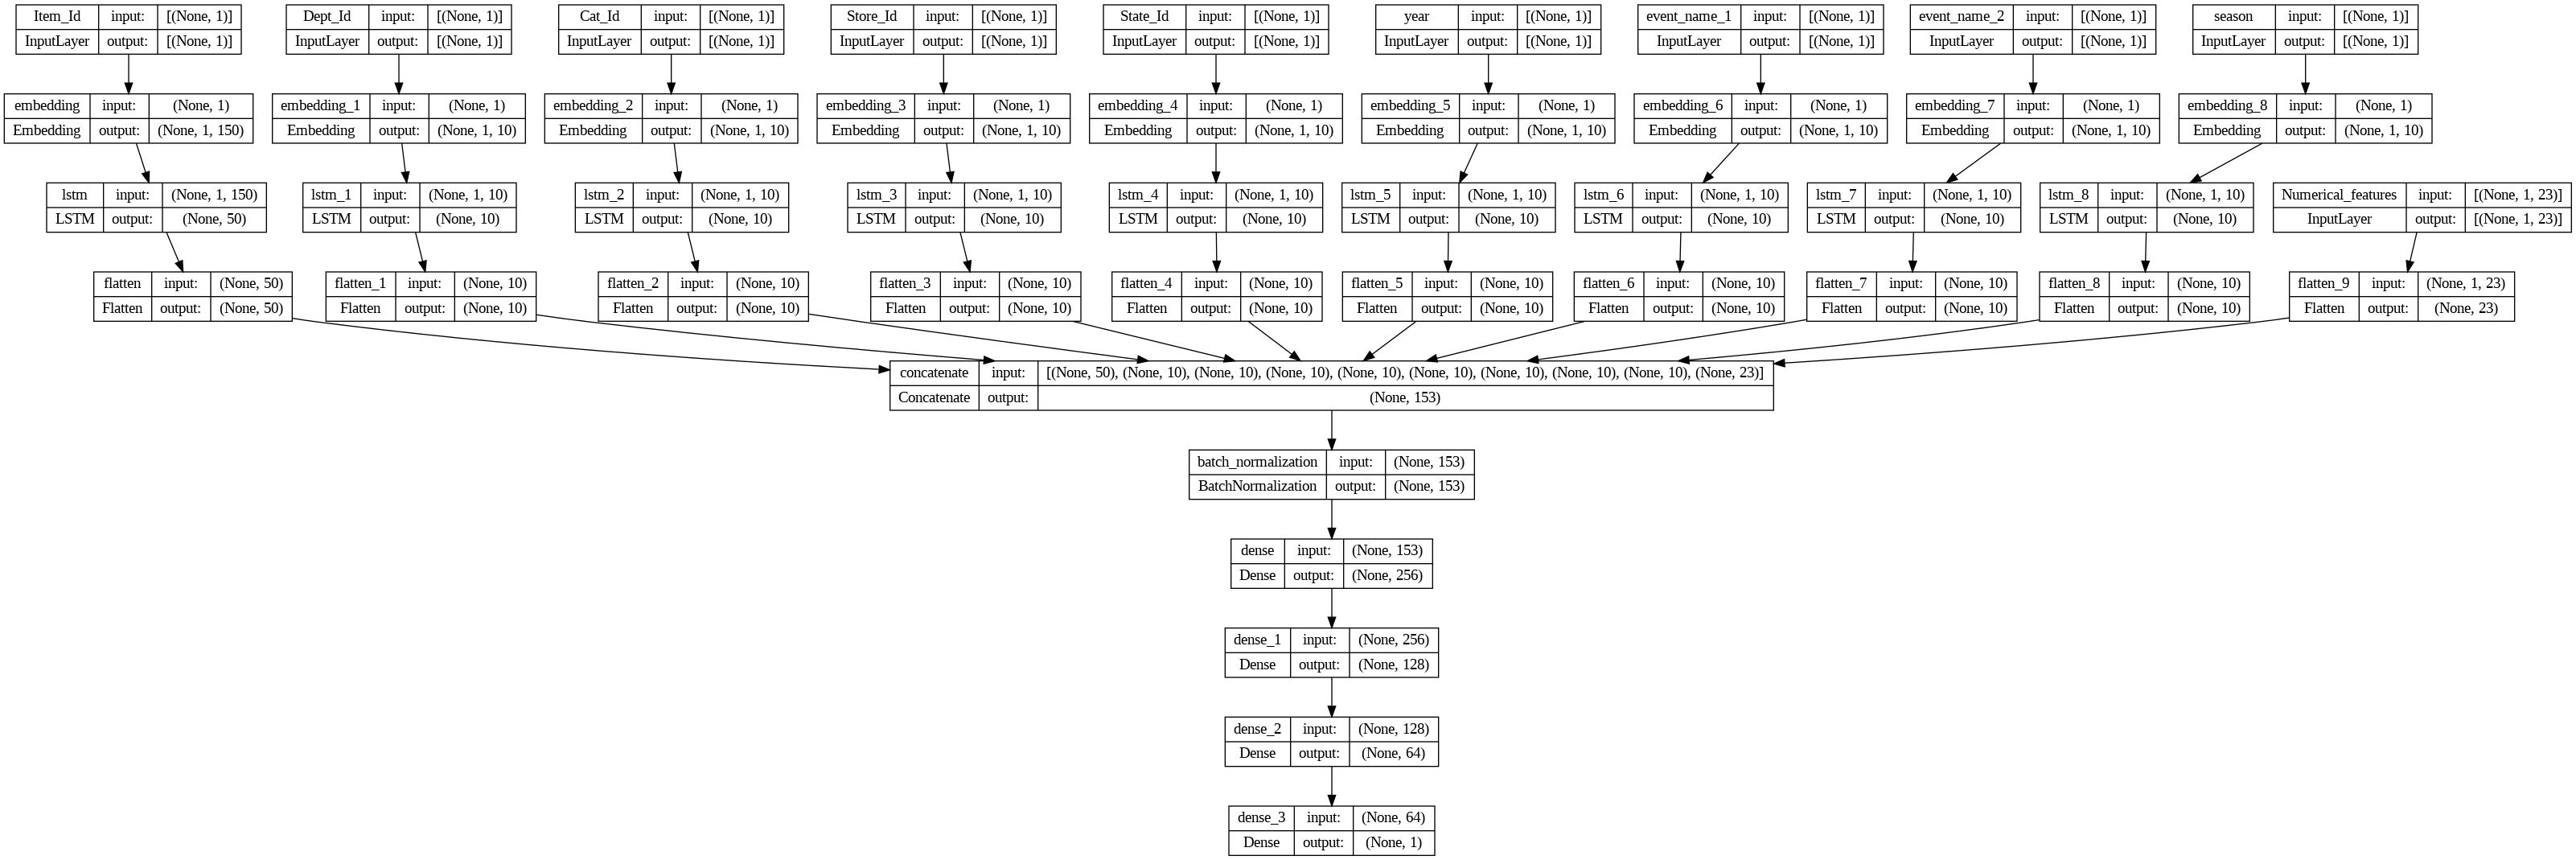

In [ ]:
tf.keras.utils.plot_model(model,show_shapes=True)

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Nadam(learning_rate=0.0009),loss='mse')

In [ ]:
model.fit(x=[train['item_id'].values.reshape(-1,1),train['dept_id'].values,train['cat_id'].values.reshape(-1,1),train['store_id'].values.reshape(-1,1),\
             train['state_id'].values.reshape(-1,1),train['year'].values.reshape(-1,1),train['event_name_1'].values.reshape(-1,1),train['event_name_2'].values.reshape(-1,1),\
             train['season'].values.reshape(-1,1),train[[ 'roll_7_shift_28_mean',
       'roll_14_shift_28_mean', 'roll_30_shift_28_mean',
       'roll_60_shift_28_mean', 'roll_360_shift_28_mean',
       'roll_7_shift_28_std', 'roll_14_shift_28_std', 'roll_30_shift_28_std',
       'roll_60_shift_28_std', 'roll_360_shift_28_std','sell_price','direct_lag_28', 'direct_lag_35', 'direct_lag_42', 'direct_lag_49',
       'direct_lag_56', 'direct_lag_63', 'direct_lag_70', 'direct_lag_77',
       'direct_lag_84', 'direct_lag_91', 'direct_lag_98','direct_ewm']].values.reshape(-1,1,23)],\
          y=train['sales'],epochs=15,verbose=1,batch_size=50000,\
          validation_data=([cv['item_id'].values.reshape(-1,1),cv['dept_id'].values,cv['cat_id'].values.reshape(-1,1),cv['store_id'].values.reshape(-1,1),\
             cv['state_id'].values.reshape(-1,1),cv['year'].values.reshape(-1,1),cv['event_name_1'].values.reshape(-1,1),cv['event_name_2'].values.reshape(-1,1),\
             cv['season'].values.reshape(-1,1),cv[[ 'roll_7_shift_28_mean',
       'roll_14_shift_28_mean', 'roll_30_shift_28_mean',
       'roll_60_shift_28_mean', 'roll_360_shift_28_mean',
       'roll_7_shift_28_std', 'roll_14_shift_28_std', 'roll_30_shift_28_std',
       'roll_60_shift_28_std', 'roll_360_shift_28_std','sell_price','direct_lag_28', 'direct_lag_35', 'direct_lag_42', 'direct_lag_49',
       'direct_lag_56', 'direct_lag_63', 'direct_lag_70', 'direct_lag_77',
       'direct_lag_84', 'direct_lag_91', 'direct_lag_98','direct_ewm']].values.reshape(-1,1,23)],cv['sales']),workers=5,use_multiprocessing=True)

Epoch 1/15
904/904 [==============================] - 58s 40ms/step - loss: 8.6961 - val_loss: 5.0771
Epoch 2/15
904/904 [==============================] - 33s 36ms/step - loss: 7.5484 - val_loss: 4.9800
Epoch 3/15
904/904 [==============================] - 33s 36ms/step - loss: 7.2638 - val_loss: 4.9380
Epoch 4/15
904/904 [==============================] - 33s 36ms/step - loss: 7.0834 - val_loss: 4.9437
Epoch 5/15
904/904 [==============================] - 33s 36ms/step - loss: 6.9497 - val_loss: 4.9647
Epoch 6/15
904/904 [==============================] - 33s 37ms/step - loss: 6.8327 - val_loss: 4.8337
Epoch 7/15
904/904 [==============================] - 33s 36ms/step - loss: 6.7536 - val_loss: 4.8123
Epoch 8/15
904/904 [==============================] - 33s 36ms/step - loss: 6.6809 - val_loss: 4.7455
Epoch 9/15
904/904 [==============================] - 33s 36ms/step - loss: 6.6248 - val_loss: 4.7996
Epoch 10/15
904/904 [==============================] - 33s 36ms/step - loss: 6.559

In [ ]:
#Predicting for test data
test['pred_sales']=model.predict([test['item_id'].values.reshape(-1,1),test['dept_id'].values,test['cat_id'].values.reshape(-1,1),test['store_id'].values.reshape(-1,1),\
             test['state_id'].values.reshape(-1,1),test['year'].values.reshape(-1,1),test['event_name_1'].values.reshape(-1,1),test['event_name_2'].values.reshape(-1,1),\
             test['season'].values.reshape(-1,1),test[['roll_7_shift_28_mean',
       'roll_14_shift_28_mean', 'roll_30_shift_28_mean',
       'roll_60_shift_28_mean', 'roll_360_shift_28_mean',
       'roll_7_shift_28_std', 'roll_14_shift_28_std', 'roll_30_shift_28_std',
       'roll_60_shift_28_std', 'roll_360_shift_28_std','sell_price','direct_lag_28', 'direct_lag_35', 'direct_lag_42', 'direct_lag_49',
       'direct_lag_56', 'direct_lag_63', 'direct_lag_70', 'direct_lag_77',
       'direct_lag_84', 'direct_lag_91', 'direct_lag_98','direct_ewm']].values.reshape(-1,1,23)])

26679/26679 [==============================] - 155s 6ms/step


In [ ]:
#predicting sales for final_test data
final_test['pred_sales']=model.predict([final_test['item_id'].values.reshape(-1,1),test['dept_id'].values,final_test['cat_id'].values.reshape(-1,1),final_test['store_id'].values.reshape(-1,1),\
             final_test['state_id'].values.reshape(-1,1),final_test['year'].values.reshape(-1,1),final_test['event_name_1'].values.reshape(-1,1),final_test['event_name_2'].values.reshape(-1,1),\
             final_test['season'].values.reshape(-1,1),final_test[['roll_7_shift_28_mean',
       'roll_14_shift_28_mean', 'roll_30_shift_28_mean',
       'roll_60_shift_28_mean', 'roll_360_shift_28_mean',
       'roll_7_shift_28_std', 'roll_14_shift_28_std', 'roll_30_shift_28_std',
       'roll_60_shift_28_std', 'roll_360_shift_28_std','sell_price','direct_lag_28', 'direct_lag_35', 'direct_lag_42', 'direct_lag_49',
       'direct_lag_56', 'direct_lag_63', 'direct_lag_70', 'direct_lag_77',
       'direct_lag_84', 'direct_lag_91', 'direct_lag_98','direct_ewm']].values.reshape(-1,1,23)])

26679/26679 [==============================] - 154s 6ms/step


In [ ]:
%%time
df=test.pivot_table(index='id',columns='date',values='pred_sales')
df.reset_index(level=0,inplace=True)
df['id']=df['id'].apply(lambda x:x.replace('evaluation','validation'))
dic={}
l=test['date'].unique()
for i,day in enumerate(l):
    dic[day]='F'+str(i+1)
df.rename(columns=dic,inplace=True) 

CPU times: user 694 ms, sys: 0 ns, total: 694 ms
Wall time: 715 ms


In [ ]:
df

date,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,FOODS_1_001_CA_1_validation,0.722432,0.591828,0.580754,0.579958,0.815359,0.682956,0.532700,0.922008,0.623999,...,0.720600,0.733497,0.566232,1.160035,0.562106,0.760437,0.484605,0.702088,0.718765,0.528460
1,FOODS_1_001_CA_2_validation,1.063358,0.760091,0.598076,0.698987,0.503254,1.165879,0.765154,1.031192,0.749424,...,0.569383,0.902964,1.485618,0.883312,0.748798,0.806379,0.836643,0.531848,0.733254,1.504965
2,FOODS_1_001_CA_3_validation,0.811180,0.653323,0.695720,0.787368,0.744437,1.768113,1.252145,0.751686,0.624266,...,0.675409,1.478672,2.139215,0.753628,0.565243,0.658144,0.726664,0.662420,1.468969,1.708863
3,FOODS_1_001_CA_4_validation,0.529003,0.248581,0.275726,0.264687,0.323709,0.333690,0.269723,0.559774,0.248331,...,0.309607,0.282666,0.248090,0.557948,0.248581,0.289887,0.258758,0.327983,0.316222,0.282427
4,FOODS_1_001_TX_1_validation,0.392289,0.379719,0.354289,0.356820,0.380097,0.317430,0.530196,0.368643,0.425949,...,0.336333,0.303865,0.433136,0.345762,0.379600,0.326717,0.326879,0.330661,0.299615,0.396269
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,HOUSEHOLD_2_516_TX_2_validation,0.196847,0.165678,0.237523,0.257554,0.281656,0.219468,0.212295,0.188301,0.214379,...,0.227627,0.254418,0.244651,0.204931,0.177875,0.234529,0.192191,0.237751,0.224206,0.217723
30486,HOUSEHOLD_2_516_TX_3_validation,0.094056,0.144387,0.130494,0.106705,0.107536,0.128456,0.136026,0.094223,0.175064,...,0.170257,0.120383,0.104584,0.091191,0.116839,0.119760,0.096143,0.099011,0.114477,0.101226
30487,HOUSEHOLD_2_516_WI_1_validation,0.127950,0.141243,0.124119,0.130735,0.122999,0.149161,0.154146,0.128077,0.137195,...,0.149921,0.131385,0.123049,0.123032,0.135081,0.122993,0.122902,0.143597,0.132061,0.124001
30488,HOUSEHOLD_2_516_WI_2_validation,0.150219,0.141744,0.140316,0.152363,0.151532,0.188835,0.187825,0.147407,0.141553,...,0.150995,0.155082,0.145830,0.145835,0.145835,0.145831,0.177641,0.152800,0.145212,0.144586


In [ ]:
%%time
df1=final_test.pivot_table(index='id',columns='d',values='pred_sales')
df1.reset_index(level=0,inplace=True)
dic={}
for i,day in enumerate(range(1942,1970)):
    dic['d_'+str(day)]='F'+str(i+1)
df1.rename(columns=dic,inplace=True)    

CPU times: user 603 ms, sys: 0 ns, total: 603 ms
Wall time: 600 ms


In [ ]:
df2=pd.concat([df1,df])

In [ ]:
#We have then submitted this Csv file in kaggle to get scores
df2.to_csv('NN.csv',index=False)

In [ ]:
df1

d,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,FOODS_1_001_CA_1_evaluation,1.114996,0.522792,0.663883,0.421599,0.637514,0.721305,0.515454,1.067955,0.917557,...,0.832875,0.781397,0.570051,0.797964,0.835928,0.546839,0.487573,0.732055,0.682239,0.356935
1,FOODS_1_001_CA_2_evaluation,0.744752,0.919919,0.739570,0.757543,0.487540,0.834682,1.545231,0.815644,0.794967,...,0.761403,0.793199,1.577074,0.897968,0.977850,0.833511,0.768898,0.798879,0.833112,1.223009
2,FOODS_1_001_CA_3_evaluation,0.773044,0.570032,0.719382,0.645887,1.358012,1.437115,1.437078,0.795078,0.649588,...,0.745030,1.011404,1.143345,0.447391,0.364692,0.473768,0.352993,0.986664,1.091694,1.089477
3,FOODS_1_001_CA_4_evaluation,0.490972,0.282165,0.280232,0.254937,0.310352,0.302319,0.309250,0.547848,0.275726,...,0.298282,0.272954,0.259964,0.333647,0.234402,0.264342,0.251742,0.283034,0.278068,0.085245
4,FOODS_1_001_TX_1_evaluation,0.325808,0.332319,0.379952,0.305715,0.386758,0.293995,0.444414,0.384631,0.389729,...,0.282309,0.303892,0.367092,0.286753,0.461235,0.275061,0.317250,0.335949,0.293809,0.400859
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,HOUSEHOLD_2_516_TX_2_evaluation,0.199639,0.175777,0.214991,0.192839,0.212724,0.195341,0.202236,0.257208,0.174472,...,0.148907,0.185551,0.159270,0.214092,0.136564,0.145651,0.141037,0.158372,0.172053,0.223554
30486,HOUSEHOLD_2_516_TX_3_evaluation,0.091827,0.115509,0.112788,0.098766,0.096690,0.111334,0.134925,0.060037,0.115302,...,0.112623,0.150679,0.136979,0.092661,0.102404,0.107903,0.110508,0.150759,0.160287,0.239275
30487,HOUSEHOLD_2_516_WI_1_evaluation,0.151500,0.134797,0.123991,0.151447,0.138593,0.129502,0.123342,0.146204,0.132501,...,0.125137,0.167493,0.113550,0.124546,0.113437,0.113379,0.124474,0.166345,0.154047,-0.010108
30488,HOUSEHOLD_2_516_WI_2_evaluation,0.144620,0.144620,0.144510,0.170042,0.148264,0.142556,0.141948,0.158007,0.141948,...,0.051429,0.051403,0.088369,0.088573,0.050361,0.050328,0.066300,0.050328,0.049517,0.153920


In [ ]:
df2

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,FOODS_1_001_CA_1_evaluation,1.114996,0.522792,0.663883,0.421599,0.637514,0.721305,0.515454,1.067955,0.917557,...,0.832875,0.781397,0.570051,0.797964,0.835928,0.546839,0.487573,0.732055,0.682239,0.356935
1,FOODS_1_001_CA_2_evaluation,0.744752,0.919919,0.739570,0.757543,0.487540,0.834682,1.545231,0.815644,0.794967,...,0.761403,0.793199,1.577074,0.897968,0.977850,0.833511,0.768898,0.798879,0.833112,1.223009
2,FOODS_1_001_CA_3_evaluation,0.773044,0.570032,0.719382,0.645887,1.358012,1.437115,1.437078,0.795078,0.649588,...,0.745030,1.011404,1.143345,0.447391,0.364692,0.473768,0.352993,0.986664,1.091694,1.089477
3,FOODS_1_001_CA_4_evaluation,0.490972,0.282165,0.280232,0.254937,0.310352,0.302319,0.309250,0.547848,0.275726,...,0.298282,0.272954,0.259964,0.333647,0.234402,0.264342,0.251742,0.283034,0.278068,0.085245
4,FOODS_1_001_TX_1_evaluation,0.325808,0.332319,0.379952,0.305715,0.386758,0.293995,0.444414,0.384631,0.389729,...,0.282309,0.303892,0.367092,0.286753,0.461235,0.275061,0.317250,0.335949,0.293809,0.400859
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,HOUSEHOLD_2_516_TX_2_validation,0.196847,0.165678,0.237523,0.257554,0.281656,0.219468,0.212295,0.188301,0.214379,...,0.227627,0.254418,0.244651,0.204931,0.177875,0.234529,0.192191,0.237751,0.224206,0.217723
30486,HOUSEHOLD_2_516_TX_3_validation,0.094056,0.144387,0.130494,0.106705,0.107536,0.128456,0.136026,0.094223,0.175064,...,0.170257,0.120383,0.104584,0.091191,0.116839,0.119760,0.096143,0.099011,0.114477,0.101226
30487,HOUSEHOLD_2_516_WI_1_validation,0.127950,0.141243,0.124119,0.130735,0.122999,0.149161,0.154146,0.128077,0.137195,...,0.149921,0.131385,0.123049,0.123032,0.135081,0.122993,0.122902,0.143597,0.132061,0.124001
30488,HOUSEHOLD_2_516_WI_2_validation,0.150219,0.141744,0.140316,0.152363,0.151532,0.188835,0.187825,0.147407,0.141553,...,0.150995,0.155082,0.145830,0.145835,0.145835,0.145831,0.177641,0.152800,0.145212,0.144586


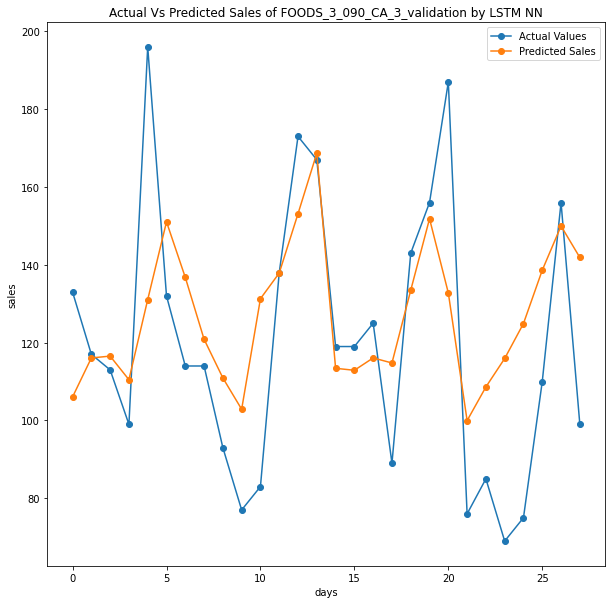

In [ ]:
#see how predicted sales varies form actual for FOODS_3_090_CA_3_validation
nn=pd.read_csv('NN.csv')
test.sort_values(['id','date'],inplace=True)
tt=test.pivot_table(index='id',values='sales',columns='d')
tt.reset_index(level=0,inplace=True)
tt['id']=tt['id'].apply(lambda x:x.replace('evaluation','validation'))
actual_sales=tt[tt['id']=='FOODS_3_090_CA_3_validation'].values.flatten()[1:]
pred_sales=nn[nn['id']=='FOODS_3_090_CA_3_validation'].values.flatten()[1:]
plt.figure(figsize=(10,10))
plt.plot(actual_sales,label='Actual Values',marker='o')
plt.plot(pred_sales,label='Predicted Sales',marker='o')
plt.title("Actual Vs Predicted Sales of FOODS_3_090_CA_3_validation by LSTM NN")
plt.ylabel('sales')
plt.xlabel('days')
plt.legend()
plt.show()

## LSTM-CNN

In [ ]:
#CNN-LSTM
tf.keras.backend.clear_session()
input1=tf.keras.layers.Input(shape=1,name='Item_Id')
input2=tf.keras.layers.Input(shape=1,name='Dept_Id')
input3=tf.keras.layers.Input(shape=1,name='Cat_Id')
input4=tf.keras.layers.Input(shape=1,name='Store_Id')
input5=tf.keras.layers.Input(shape=1,name='State_Id')
input6=tf.keras.layers.Input(shape=1,name='year')
input7=tf.keras.layers.Input(shape=1,name='event_name_1')
input8=tf.keras.layers.Input(shape=1,name='event_name_2')
input9=tf.keras.layers.Input(shape=1,name='season')
input10=tf.keras.layers.Input(shape=(1,23),name='Numerical_features')

emb1=tf.keras.layers.Embedding(3050,output_dim=150)(input1)
emb1=tf.keras.layers.Conv1D(7,8,padding='same',activation='relu')(emb1)

emb2=tf.keras.layers.Embedding(8,output_dim=10)(input2)
emb2=tf.keras.layers.Conv1D(3,8,padding='same',activation='sigmoid')(emb2)

emb3=tf.keras.layers.Embedding(4,output_dim=10)(input3)
emb3=tf.keras.layers.Conv1D(5,8,padding='same',activation='relu')(emb3)

emb4=tf.keras.layers.Embedding(11,output_dim=10)(input4)
emb4=tf.keras.layers.Conv1D(5,8,padding='same',activation='tanh')(emb4)

emb5=tf.keras.layers.Embedding(4,output_dim=10)(input5)
emb5=tf.keras.layers.Conv1D(5,8,padding='same',activation='relu')(emb5)

emb6=tf.keras.layers.Embedding(2017,output_dim=10)(input6)
emb6=tf.keras.layers.Conv1D(5,8,padding='same',activation='sigmoid')(emb6)

emb7=tf.keras.layers.Embedding(32,output_dim=10)(input7)
emb7=tf.keras.layers.Conv1D(3,8,padding='same',activation='relu')(emb7)

emb8=tf.keras.layers.Embedding(6,output_dim=10)(input8)
emb8=tf.keras.layers.Conv1D(3,8,padding='same',activation='relu')(emb8)

emb9=tf.keras.layers.Embedding(5,output_dim=10)(input9)
emb9=tf.keras.layers.Conv1D(3,8,padding='same',activation='relu')(emb9)

emb10=tf.keras.layers.Conv1D(3,16,padding='same',activation='tanh')(input10)

lstm1=tf.keras.layers.LSTM(50)(emb1)
lstm2=tf.keras.layers.LSTM(10)(emb2)
lstm3=tf.keras.layers.LSTM(10)(emb3)
lstm4=tf.keras.layers.LSTM(10)(emb4)
lstm5=tf.keras.layers.LSTM(10)(emb5)
lstm6=tf.keras.layers.LSTM(10)(emb6)
lstm7=tf.keras.layers.LSTM(10)(emb7)
lstm8=tf.keras.layers.LSTM(10)(emb8)
lstm9=tf.keras.layers.LSTM(10)(emb9)
lstm10=tf.keras.layers.LSTM(32)(emb10)

x1=tf.keras.layers.Flatten()(lstm1)
x2=tf.keras.layers.Flatten()(lstm2)
x3=tf.keras.layers.Flatten()(lstm3)
x4=tf.keras.layers.Flatten()(lstm4)
x5=tf.keras.layers.Flatten()(lstm5)
x6=tf.keras.layers.Flatten()(lstm6)
x7=tf.keras.layers.Flatten()(lstm7)
x8=tf.keras.layers.Flatten()(lstm8)
x9=tf.keras.layers.Flatten()(lstm9)
x10=tf.keras.layers.Flatten()(lstm10)


x=tf.keras.layers.Concatenate()([x1,x2,x3,x4,x5,x6,x7,x8,x9,x10])
x=tf.keras.layers.BatchNormalization()(x)
x=tf.keras.layers.Dense(256,activation='sigmoid')(x)
x=tf.keras.layers.Dense(128,activation='tanh')(x)
x=tf.keras.layers.Dense(64,activation='relu')(x)
x=tf.keras.layers.Dense(1)(x)
model=tf.keras.Model([input1,input2,input3,input4,input5,input6,input7,input8,input9,input10],x)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Item_Id (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 Dept_Id (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 Cat_Id (InputLayer)            [(None, 1)]          0           []                               
                                                                                                  
 Store_Id (InputLayer)          [(None, 1)]          0           []                               
                                                                                              

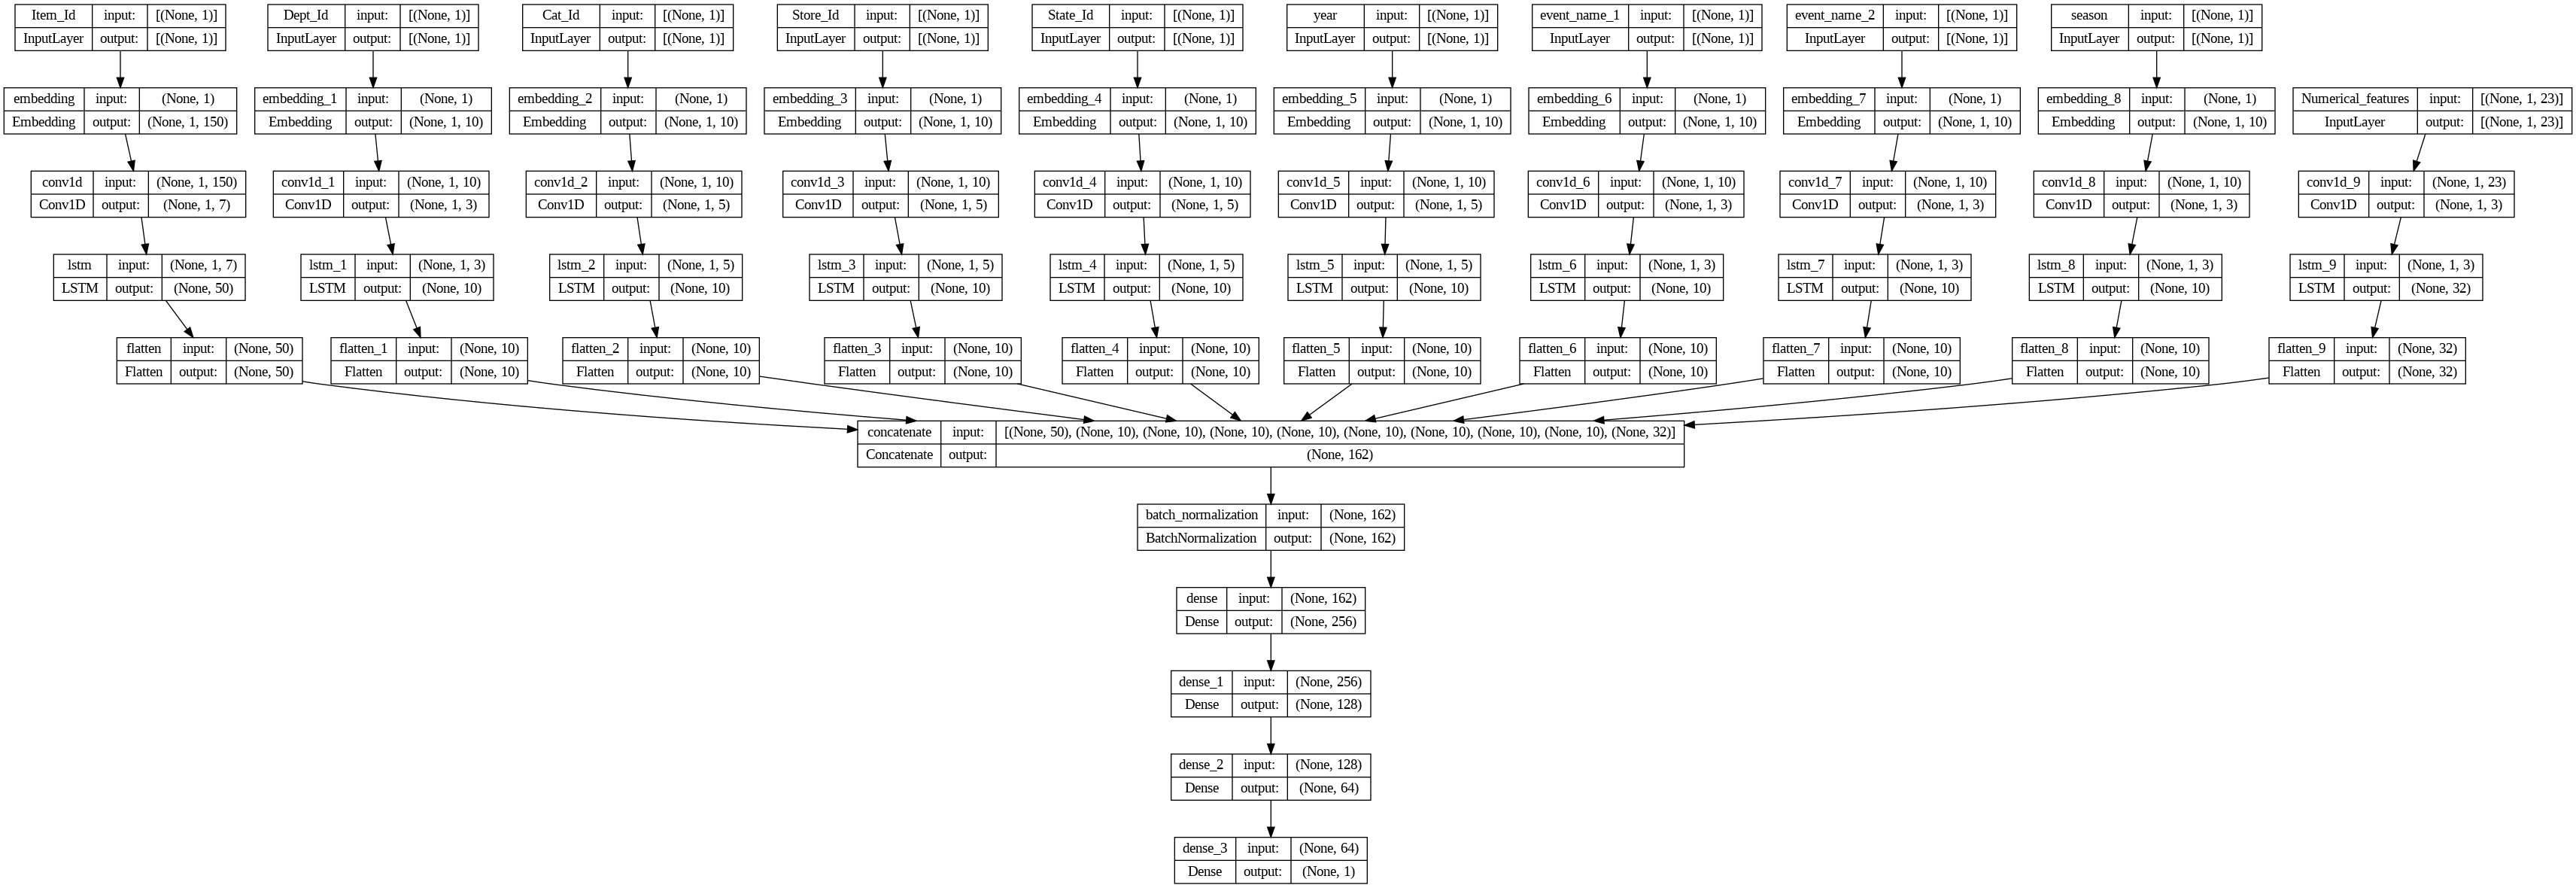

In [ ]:
tf.keras.utils.plot_model(model,show_shapes=True)

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Nadam(learning_rate=0.001),loss='mse')

In [ ]:
model.fit(x=[train['item_id'].values.reshape(-1,1),train['dept_id'].values,train['cat_id'].values.reshape(-1,1),train['store_id'].values.reshape(-1,1),\
             train['state_id'].values.reshape(-1,1),train['year'].values.reshape(-1,1),train['event_name_1'].values.reshape(-1,1),train['event_name_2'].values.reshape(-1,1),\
             train['season'].values.reshape(-1,1),train[[ 'roll_7_shift_28_mean',
       'roll_14_shift_28_mean', 'roll_30_shift_28_mean',
       'roll_60_shift_28_mean', 'roll_360_shift_28_mean',
       'roll_7_shift_28_std', 'roll_14_shift_28_std', 'roll_30_shift_28_std',
       'roll_60_shift_28_std', 'roll_360_shift_28_std','sell_price','direct_lag_28', 'direct_lag_35', 'direct_lag_42', 'direct_lag_49',
       'direct_lag_56', 'direct_lag_63', 'direct_lag_70', 'direct_lag_77',
       'direct_lag_84', 'direct_lag_91', 'direct_lag_98','direct_ewm']].values.reshape(-1,1,23)],\
          y=train['sales'],epochs=10,verbose=1,batch_size=50000,\
          validation_data=([cv['item_id'].values.reshape(-1,1),cv['dept_id'].values,cv['cat_id'].values.reshape(-1,1),cv['store_id'].values.reshape(-1,1),\
             cv['state_id'].values.reshape(-1,1),cv['year'].values.reshape(-1,1),cv['event_name_1'].values.reshape(-1,1),cv['event_name_2'].values.reshape(-1,1),\
             cv['season'].values.reshape(-1,1),cv[[ 'roll_7_shift_28_mean',
       'roll_14_shift_28_mean', 'roll_30_shift_28_mean',
       'roll_60_shift_28_mean', 'roll_360_shift_28_mean',
       'roll_7_shift_28_std', 'roll_14_shift_28_std', 'roll_30_shift_28_std',
       'roll_60_shift_28_std', 'roll_360_shift_28_std','sell_price','direct_lag_28', 'direct_lag_35', 'direct_lag_42', 'direct_lag_49',
       'direct_lag_56', 'direct_lag_63', 'direct_lag_70', 'direct_lag_77',
       'direct_lag_84', 'direct_lag_91', 'direct_lag_98','direct_ewm']].values.reshape(-1,1,23)],cv['sales']),use_multiprocessing=True,workers=7)

Epoch 1/10
904/904 [==============================] - 91s 53ms/step - loss: 8.8526 - val_loss: 4.9324
Epoch 2/10
904/904 [==============================] - 43s 48ms/step - loss: 7.7901 - val_loss: 5.1261
Epoch 3/10
904/904 [==============================] - 43s 47ms/step - loss: 7.5651 - val_loss: 5.0775
Epoch 4/10
904/904 [==============================] - 43s 48ms/step - loss: 7.4735 - val_loss: 4.9934
Epoch 5/10
904/904 [==============================] - 43s 48ms/step - loss: 7.4072 - val_loss: 5.0682
Epoch 6/10
904/904 [==============================] - 43s 48ms/step - loss: 7.3079 - val_loss: 4.9258
Epoch 7/10
904/904 [==============================] - 43s 48ms/step - loss: 7.2675 - val_loss: 4.9931
Epoch 8/10
904/904 [==============================] - 43s 48ms/step - loss: 7.2205 - val_loss: 4.9834
Epoch 9/10
904/904 [==============================] - 43s 48ms/step - loss: 7.1527 - val_loss: 5.1228
Epoch 10/10
904/904 [==============================] - 43s 48ms/step - loss: 7.107

In [ ]:
test['pred_sales']=model.predict([test['item_id'].values.reshape(-1,1),test['dept_id'].values,test['cat_id'].values.reshape(-1,1),test['store_id'].values.reshape(-1,1),\
             test['state_id'].values.reshape(-1,1),test['year'].values.reshape(-1,1),test['event_name_1'].values.reshape(-1,1),test['event_name_2'].values.reshape(-1,1),\
             test['season'].values.reshape(-1,1),test[['roll_7_shift_28_mean',
       'roll_14_shift_28_mean', 'roll_30_shift_28_mean',
       'roll_60_shift_28_mean', 'roll_360_shift_28_mean',
       'roll_7_shift_28_std', 'roll_14_shift_28_std', 'roll_30_shift_28_std',
       'roll_60_shift_28_std', 'roll_360_shift_28_std','sell_price','direct_lag_28', 'direct_lag_35', 'direct_lag_42', 'direct_lag_49',
       'direct_lag_56', 'direct_lag_63', 'direct_lag_70', 'direct_lag_77',
       'direct_lag_84', 'direct_lag_91', 'direct_lag_98','direct_ewm']].values.reshape(-1,1,23)])

23036/26679 [========================>.....] - ETA: 26s

In [ ]:
final_test['pred_sales']=model.predict([final_test['item_id'].values.reshape(-1,1),test['dept_id'].values,final_test['cat_id'].values.reshape(-1,1),final_test['store_id'].values.reshape(-1,1),\
             final_test['state_id'].values.reshape(-1,1),final_test['year'].values.reshape(-1,1),final_test['event_name_1'].values.reshape(-1,1),final_test['event_name_2'].values.reshape(-1,1),\
             final_test['season'].values.reshape(-1,1),final_test[['roll_7_shift_28_mean',
       'roll_14_shift_28_mean', 'roll_30_shift_28_mean',
       'roll_60_shift_28_mean', 'roll_360_shift_28_mean',
       'roll_7_shift_28_std', 'roll_14_shift_28_std', 'roll_30_shift_28_std',
       'roll_60_shift_28_std', 'roll_360_shift_28_std','sell_price','direct_lag_28', 'direct_lag_35', 'direct_lag_42', 'direct_lag_49',
       'direct_lag_56', 'direct_lag_63', 'direct_lag_70', 'direct_lag_77',
       'direct_lag_84', 'direct_lag_91', 'direct_lag_98','direct_ewm']].values.reshape(-1,1,23)])

26679/26679 [==============================] - 192s 7ms/step


In [ ]:
%%time
df=test.pivot_table(index='id',columns='date',values='pred_sales')
df.reset_index(level=0,inplace=True)
df['id']=df['id'].apply(lambda x:x.replace('evaluation','validation'))
dic={}
l=test['date'].unique()
for i,day in enumerate(l):
    dic[day]='F'+str(i+1)
df.rename(columns=dic,inplace=True) 

CPU times: user 712 ms, sys: 0 ns, total: 712 ms
Wall time: 729 ms


In [ ]:
%%time
df1=final_test.pivot_table(index='id',columns='d',values='pred_sales')
df1.reset_index(level=0,inplace=True)
dic={}
for i,day in enumerate(range(1942,1970)):
    dic['d_'+str(day)]='F'+str(i+1)
df1.rename(columns=dic,inplace=True)    

CPU times: user 620 ms, sys: 0 ns, total: 620 ms
Wall time: 617 ms


In [ ]:
df2=pd.concat([df1,df])

In [ ]:
df2.to_csv('CNN.csv',index=False)

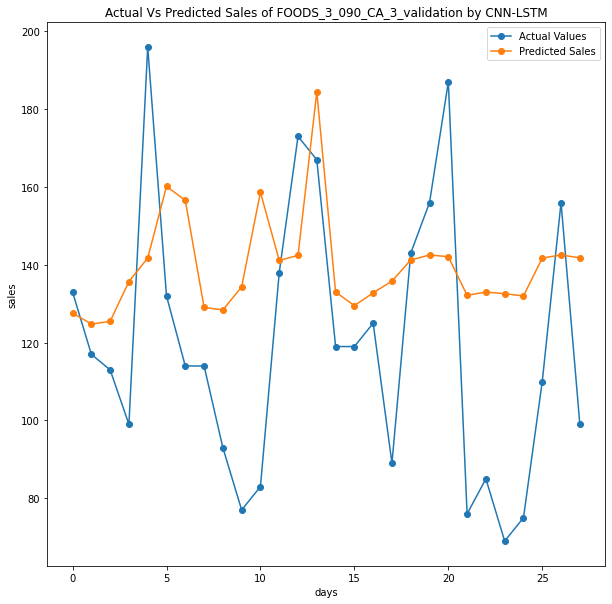

In [ ]:
#see how predicted sales varies form actual for FOODS_3_090_CA_3_validation
nn=pd.read_csv('CNN.csv')
test.sort_values(['id','date'],inplace=True)
tt=test.pivot_table(index='id',values='sales',columns='d')
tt.reset_index(level=0,inplace=True)
tt['id']=tt['id'].apply(lambda x:x.replace('evaluation','validation'))
actual_sales=tt[tt['id']=='FOODS_3_090_CA_3_validation'].values.flatten()[1:]
pred_sales=nn[nn['id']=='FOODS_3_090_CA_3_validation'].values.flatten()[1:]
plt.figure(figsize=(10,10))
plt.plot(actual_sales,label='Actual Values',marker='o')
plt.plot(pred_sales,label='Predicted Sales',marker='o')
plt.title("Actual Vs Predicted Sales of FOODS_3_090_CA_3_validation by CNN-LSTM")
plt.ylabel('sales')
plt.xlabel('days')
plt.legend()
plt.show()

In [ ]:
train.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,date,wday,...,direct_lag_35,direct_lag_42,direct_lag_49,direct_lag_56,direct_lag_63,direct_lag_70,direct_lag_77,direct_lag_84,direct_lag_91,direct_lag_98
0,HOBBIES_1_008_CA_1_validation,1444,3,1,0,0,d_1,12,2011-01-29,1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
1,HOBBIES_1_008_CA_1_validation,1444,3,1,0,0,d_2,15,2011-01-30,2,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
2,HOBBIES_1_008_CA_1_validation,1444,3,1,0,0,d_3,0,2011-01-31,3,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
3,HOBBIES_1_008_CA_1_validation,1444,3,1,0,0,d_4,0,2011-02-01,4,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
4,HOBBIES_1_008_CA_1_validation,1444,3,1,0,0,d_5,0,2011-02-02,5,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1


## Linear Regression

In [ ]:
#Code Snippet to prepare data for serveral Models in which we pass sparse matrix
#converting item_id into string so that it can be used by Count Vectorizer
train['item_id']=train['item_id'].apply(lambda x:str(x))
cv['item_id']=cv['item_id'].apply(lambda x:str(x))
test['item_id']=test['item_id'].apply(lambda x:str(x))
final_test['item_id']=final_test['item_id'].apply(lambda x:str(x))


vec_item_id=CountVectorizer(binary=True)
train_id=vec_item_id.fit_transform(train['item_id'])
train_season=csr_matrix(tf.keras.utils.to_categorical(train['season'],4))
train_month=csr_matrix(tf.keras.utils.to_categorical(train['month'],13))
train_wday=csr_matrix(tf.keras.utils.to_categorical(train['wday'],8))

train_dept=csr_matrix(tf.keras.utils.to_categorical(train['dept_id'],7))
train_en1=csr_matrix(tf.keras.utils.to_categorical(train['event_name_1'],31))
train_en2=csr_matrix(tf.keras.utils.to_categorical(train['event_name_2'],5))
train_et1=csr_matrix(tf.keras.utils.to_categorical(train['event_type_1'],5))
train_et2=csr_matrix(tf.keras.utils.to_categorical(train['event_type_2'],3))
train_yr=csr_matrix(tf.keras.utils.to_categorical(train['year'],6))
train_yr_st=csr_matrix(tf.keras.utils.to_categorical(train['year_start'],2))
train_yr_end=csr_matrix(tf.keras.utils.to_categorical(train['year_end'],2))
train_qt_st=csr_matrix(tf.keras.utils.to_categorical(train['quater_start'],2))
train_qt_end=csr_matrix(tf.keras.utils.to_categorical(train['quater_end'],2))
train_month_st=csr_matrix(tf.keras.utils.to_categorical(train['month_start'],2))
train_month_end=csr_matrix(tf.keras.utils.to_categorical(train['month_end'],2))

In [ ]:
train.columns

Index(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'd',
       'sales', 'date', 'wday', 'month', 'year', 'event_name_1',
       'event_type_1', 'event_name_2', 'event_type_2', 'snap_CA', 'snap_TX',
       'snap_WI', 'sell_price', 'week_number', 'season', 'quater_start',
       'quater_end', 'month_start', 'month_end', 'year_start', 'year_end',
       'roll_7_shift_28_mean', 'roll_14_shift_28_mean',
       'roll_30_shift_28_mean', 'roll_60_shift_28_mean',
       'roll_360_shift_28_mean', 'roll_7_shift_28_std', 'roll_14_shift_28_std',
       'roll_30_shift_28_std', 'roll_60_shift_28_std', 'roll_360_shift_28_std',
       'direct_ewm', 'direct_lag_28', 'direct_lag_35', 'direct_lag_42',
       'direct_lag_49', 'direct_lag_56', 'direct_lag_63', 'direct_lag_70',
       'direct_lag_77', 'direct_lag_84', 'direct_lag_91', 'direct_lag_98'],
      dtype='object')

In [ ]:
train_snap_CA=csr_matrix(tf.keras.utils.to_categorical(train['snap_CA'],2))
train_snap_WI=csr_matrix(tf.keras.utils.to_categorical(train['snap_WI'],2))
train_snap_TX=csr_matrix(tf.keras.utils.to_categorical(train['snap_TX'],2))

In [ ]:
cv_id=vec_item_id.transform(cv['item_id'])
cv_season=csr_matrix(tf.keras.utils.to_categorical(cv['season'],4))
cv_month=csr_matrix(tf.keras.utils.to_categorical(cv['month'],13))
cv_wday=csr_matrix(tf.keras.utils.to_categorical(cv['wday'],8))

cv_dept=csr_matrix(tf.keras.utils.to_categorical(cv['dept_id'],7))
cv_en1=csr_matrix(tf.keras.utils.to_categorical(cv['event_name_1'],31))
cv_en2=csr_matrix(tf.keras.utils.to_categorical(cv['event_name_2'],5))
cv_et1=csr_matrix(tf.keras.utils.to_categorical(cv['event_type_1'],5))
cv_et2=csr_matrix(tf.keras.utils.to_categorical(cv['event_type_2'],3))
cv_yr=csr_matrix(tf.keras.utils.to_categorical(cv['year'],6))
cv_yr_st=csr_matrix(tf.keras.utils.to_categorical(cv['year_start'],2))
cv_yr_end=csr_matrix(tf.keras.utils.to_categorical(cv['year_end'],2))
cv_qt_st=csr_matrix(tf.keras.utils.to_categorical(cv['quater_start'],2))
cv_qt_end=csr_matrix(tf.keras.utils.to_categorical(cv['quater_end'],2))
cv_month_st=csr_matrix(tf.keras.utils.to_categorical(cv['month_start'],2))
cv_month_end=csr_matrix(tf.keras.utils.to_categorical(cv['month_end'],2))


test_id=vec_item_id.transform(test['item_id'])
test_season=csr_matrix(tf.keras.utils.to_categorical(test['season'],4))
test_month=csr_matrix(tf.keras.utils.to_categorical(test['month'],13))
test_wday=csr_matrix(tf.keras.utils.to_categorical(test['wday'],8))

test_dept=csr_matrix(tf.keras.utils.to_categorical(test['dept_id'],7))
test_en1=csr_matrix(tf.keras.utils.to_categorical(test['event_name_1'],31))
test_en2=csr_matrix(tf.keras.utils.to_categorical(test['event_name_2'],5))
test_et1=csr_matrix(tf.keras.utils.to_categorical(test['event_type_1'],5))
test_et2=csr_matrix(tf.keras.utils.to_categorical(test['event_type_2'],3))
test_yr=csr_matrix(tf.keras.utils.to_categorical(test['year'],6))
test_yr_st=csr_matrix(tf.keras.utils.to_categorical(test['year_start'],2))
test_yr_end=csr_matrix(tf.keras.utils.to_categorical(test['year_end'],2))
test_qt_st=csr_matrix(tf.keras.utils.to_categorical(test['quater_start'],2))
test_qt_end=csr_matrix(tf.keras.utils.to_categorical(test['quater_end'],2))
test_month_st=csr_matrix(tf.keras.utils.to_categorical(test['month_start'],2))
test_month_end=csr_matrix(tf.keras.utils.to_categorical(test['month_end'],2))

In [ ]:
test_snap_CA=csr_matrix(tf.keras.utils.to_categorical(test['snap_CA'],2))
test_snap_WI=csr_matrix(tf.keras.utils.to_categorical(test['snap_WI'],2))
test_snap_TX=csr_matrix(tf.keras.utils.to_categorical(test['snap_TX'],2))

In [ ]:
cv_snap_CA=csr_matrix(tf.keras.utils.to_categorical(cv['snap_CA'],2))
cv_snap_WI=csr_matrix(tf.keras.utils.to_categorical(cv['snap_WI'],2))
cv_snap_TX=csr_matrix(tf.keras.utils.to_categorical(cv['snap_TX'],2))

In [ ]:
final_test_id=vec_item_id.transform(final_test['item_id'])
final_test_season=csr_matrix(tf.keras.utils.to_categorical(final_test['season'],4))
final_test_month=csr_matrix(tf.keras.utils.to_categorical(final_test['month'],13))
final_test_wday=csr_matrix(tf.keras.utils.to_categorical(final_test['wday'],8))

final_test_dept=csr_matrix(tf.keras.utils.to_categorical(final_test['dept_id'],7))
final_test_en1=csr_matrix(tf.keras.utils.to_categorical(final_test['event_name_1'],31))
final_test_en2=csr_matrix(tf.keras.utils.to_categorical(final_test['event_name_2'],5))
final_test_et1=csr_matrix(tf.keras.utils.to_categorical(final_test['event_type_1'],5))
final_test_et2=csr_matrix(tf.keras.utils.to_categorical(final_test['event_type_2'],3))
final_test_yr=csr_matrix(tf.keras.utils.to_categorical(final_test['year'],6))
final_test_yr_st=csr_matrix(tf.keras.utils.to_categorical(final_test['year_start'],2))
final_test_yr_end=csr_matrix(tf.keras.utils.to_categorical(final_test['year_end'],2))
final_test_qt_st=csr_matrix(tf.keras.utils.to_categorical(final_test['quater_start'],2))
final_test_qt_end=csr_matrix(tf.keras.utils.to_categorical(final_test['quater_end'],2))
final_test_month_st=csr_matrix(tf.keras.utils.to_categorical(final_test['month_start'],2))
final_test_month_end=csr_matrix(tf.keras.utils.to_categorical(final_test['month_end'],2))

X_train=hstack((train_id,train_dept,train_month,train_wday,train_yr,\
                train_snap_CA,train_snap_WI,train_snap_TX,train_en1,train_en2,train_et1,train_et2,train_yr_st,train_yr_end,
                train_qt_st,train_qt_end,train_month_st,train_month_end,\
                train['direct_lag_28'].values.reshape(-1,1),
                train['direct_lag_35'].values.reshape(-1,1),train['direct_lag_42'].values.reshape(-1,1),\
                train['direct_lag_49'].values.reshape(-1,1),train['direct_lag_56'].values.reshape(-1,1),\
                train['direct_lag_63'].values.reshape(-1,1),train['direct_lag_70'].values.reshape(-1,1),\
                train['direct_lag_77'].values.reshape(-1,1),train['direct_lag_84'].values.reshape(-1,1),\
                train['direct_lag_91'].values.reshape(-1,1),train['direct_lag_98'].values.reshape(-1,1),\
                train['sell_price'].values.reshape(-1,1))).tocsr()
y_train=train['sales'].values


In [ ]:
final_test_snap_CA=csr_matrix(tf.keras.utils.to_categorical(final_test['snap_CA'],2))
final_test_snap_WI=csr_matrix(tf.keras.utils.to_categorical(final_test['snap_WI'],2))
final_test_snap_TX=csr_matrix(tf.keras.utils.to_categorical(final_test['snap_TX'],2))

In [ ]:
X_cv=hstack((cv_id,cv_dept,cv_month,cv_wday,cv_yr,\
                cv_snap_CA,cv_snap_WI,cv_snap_TX,cv_en1,cv_en2,cv_et1,cv_et2,cv_yr_st,cv_yr_end,
                cv_qt_st,cv_qt_end,cv_month_st,cv_month_end,\
             cv['direct_lag_28'].values.reshape(-1,1),
                cv['direct_lag_35'].values.reshape(-1,1),cv['direct_lag_42'].values.reshape(-1,1),\
                cv['direct_lag_49'].values.reshape(-1,1),cv['direct_lag_56'].values.reshape(-1,1),\
                cv['direct_lag_63'].values.reshape(-1,1),cv['direct_lag_70'].values.reshape(-1,1),\
                cv['direct_lag_77'].values.reshape(-1,1),cv['direct_lag_84'].values.reshape(-1,1),\
                cv['direct_lag_91'].values.reshape(-1,1),cv['direct_lag_98'].values.reshape(-1,1),\
                cv['sell_price'].values.reshape(-1,1)
                )).tocsr()
y_cv=cv['sales'].values


X_test=hstack((test_id,test_dept,test_month,test_wday,test_yr,\
                test_snap_CA,test_snap_WI,test_snap_TX,test_en1,test_en2,test_et1,test_et2,test_yr_st,test_yr_end,
                test_qt_st,test_qt_end,test_month_st,test_month_end,\
                test['direct_lag_28'].values.reshape(-1,1),
                test['direct_lag_35'].values.reshape(-1,1),test['direct_lag_42'].values.reshape(-1,1),\
                test['direct_lag_49'].values.reshape(-1,1),test['direct_lag_56'].values.reshape(-1,1),\
                test['direct_lag_63'].values.reshape(-1,1),test['direct_lag_70'].values.reshape(-1,1),\
                test['direct_lag_77'].values.reshape(-1,1),test['direct_lag_84'].values.reshape(-1,1),\
                test['direct_lag_91'].values.reshape(-1,1),test['direct_lag_98'].values.reshape(-1,1),\
                test['sell_price'].values.reshape(-1,1))).tocsr()
y_test=test['sales'].values

X_final_test=hstack((final_test_id,final_test_dept,final_test_month,final_test_wday,final_test_yr,\
                final_test_snap_CA,final_test_snap_WI,final_test_snap_TX,final_test_en1,final_test_en2,final_test_et1,final_test_et2,final_test_yr_st,final_test_yr_end,
                final_test_qt_st,final_test_qt_end,final_test_month_st,final_test_month_end,\
               final_test['direct_lag_28'].values.reshape(-1,1),
                final_test['direct_lag_35'].values.reshape(-1,1),final_test['direct_lag_42'].values.reshape(-1,1),\
                final_test['direct_lag_49'].values.reshape(-1,1),final_test['direct_lag_56'].values.reshape(-1,1),\
                final_test['direct_lag_63'].values.reshape(-1,1),final_test['direct_lag_70'].values.reshape(-1,1),\
                final_test['direct_lag_77'].values.reshape(-1,1),final_test['direct_lag_84'].values.reshape(-1,1),\
                final_test['direct_lag_91'].values.reshape(-1,1),final_test['direct_lag_98'].values.reshape(-1,1),\
                final_test['sell_price'].values.reshape(-1,1))).tocsr()
y_final_test=final_test['sales'].values


In [ ]:
%%time
#Note here if we give data by normalizing numerical features too the model performance was same
reg=LinearRegression(n_jobs=7,normalize=True,)
reg.fit(X_train,y_train)
y_pred_tr=reg.predict(X_train)
y_pred_cv=reg.predict(X_cv)
error_tr=np.sqrt(mean_squared_error(y_train,y_pred_tr))
error_tst=np.sqrt(mean_squared_error(y_cv,y_pred_cv))
print("Linear Regression model")
print("="*15)
print("Train RMSE=",error_tr," CV RMSE=",error_tst)

Linear Regression model
Train RMSE= 2.846230575507291  CV RMSE= 2.2140566622234097
CPU times: user 2min 58s, sys: 1min 23s, total: 4min 22s
Wall time: 3min 22s


In [ ]:
test['pred_sales']=reg.predict(X_test)
final_test['pred_sales']=reg.predict(X_final_test)

In [ ]:
%%time
df=test.pivot_table(index='id',columns='date',values='pred_sales')
df.reset_index(level=0,inplace=True)
df['id']=df['id'].apply(lambda x:x.replace('evaluation','validation'))
dic={}
l=test['date'].unique()
for i,day in enumerate(l):
    dic[day]='F'+str(i+1)
df.rename(columns=dic,inplace=True) 

CPU times: user 857 ms, sys: 16.2 ms, total: 873 ms
Wall time: 893 ms


In [ ]:
%%time
df1=final_test.pivot_table(index='id',columns='d',values='pred_sales')
df1.reset_index(level=0,inplace=True)
dic={}
for i,day in enumerate(range(1942,1970)):
    dic['d_'+str(day)]='F'+str(i+1)
df1.rename(columns=dic,inplace=True)    

CPU times: user 690 ms, sys: 693 µs, total: 691 ms
Wall time: 687 ms


In [ ]:
df2=pd.concat([df1,df])

In [ ]:
df2.to_csv('linear_reg.csv',index=False)

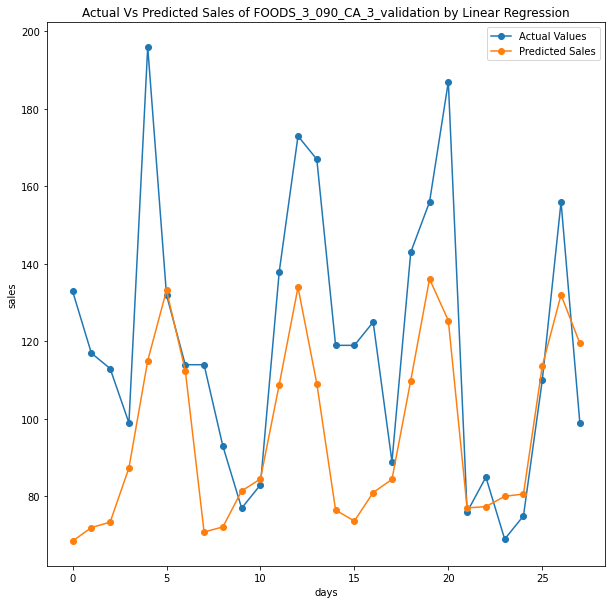

In [ ]:
#see how predicted sales varies form actual for FOODS_3_090_CA_3_validation
nn=pd.read_csv('linear_reg.csv')
test.sort_values(['id','date'],inplace=True)
tt=test.pivot_table(index='id',values='sales',columns='d')
tt.reset_index(level=0,inplace=True)
tt['id']=tt['id'].apply(lambda x:x.replace('evaluation','validation'))
actual_sales=tt[tt['id']=='FOODS_3_090_CA_3_validation'].values.flatten()[1:]
pred_sales=nn[nn['id']=='FOODS_3_090_CA_3_validation'].values.flatten()[1:]
plt.figure(figsize=(10,10))
plt.plot(actual_sales,label='Actual Values',marker='o')
plt.plot(pred_sales,label='Predicted Sales',marker='o')
plt.title("Actual Vs Predicted Sales of FOODS_3_090_CA_3_validation by Linear Regression")
plt.ylabel('sales')
plt.xlabel('days')
plt.legend()
plt.show()

## LightGbm

In [ ]:
#categorical Data's
columns=['item_id', 'dept_id', 'cat_id', 'store_id', 'state_id','wday', 'month', 'year', 'event_name_1',
       'event_type_1', 'event_name_2', 'event_type_2','snap','week_number', 'quater_start', 'quater_end', 'month_start',
       'month_end', 'year_start', 'year_end','season']

In [ ]:
data=lgb.Dataset(train.drop(['id','sales','date','d'],axis=1),label=train['sales'],categorical_feature=columns,free_raw_data=False)
data_cv=lgb.Dataset(cv.drop(['id','sales','date','d'],axis=1),label=cv['sales'],categorical_feature=columns,free_raw_data=False )

In [ ]:
params = {
          "objective" : "tweedie",
            "metric" :"rmse",
            "n_estimators":6000,
            "force_row_wise" : True,
            "learning_rate" : 0.09,
            "nthread" : 8,
            'verbosity': 1,
            'num_iterations' : 1000,
    'tweedie_variance_power': 1.1,
    'max_bin': 127,
    'bin_construct_sample_cnt':20000000,
    'num_leaves': 1000,
    'min_data_in_leaf': 2**10-1,
    'learning_rate': 0.05,
    'feature_fraction':0.8,
    'bagging_fraction':0.8,
    'bagging_freq':1,
    'lambda_l2':0.1,
    'boost_from_average': True,
}

In [ ]:
%%time
m_lgb=lgb.train(params,data,verbose_eval=1,valid_sets=[data,data_cv],early_stopping_rounds=5)

In [ ]:
test['pred_sales']=m_lgb.predict(test.drop(['id','sales','date','d'],axis=1))
final_test['pred_sales']=m_lgb.predict(final_test.drop(['id','sales','date','d'],axis=1))

In [ ]:
%%time
df=test.pivot_table(index='id',columns='date',values='pred_sales')
df.reset_index(level=0,inplace=True)
df['id']=df['id'].apply(lambda x:x.replace('evaluation','validation'))
dic={}
l=test['date'].unique()
for i,day in enumerate(l):
    dic[day]='F'+str(i+1)
df.rename(columns=dic,inplace=True)

In [ ]:
%%time
df1=final_test.pivot_table(index='id',columns='d',values='pred_sales')
df1.reset_index(level=0,inplace=True)
dic={}
for i,day in enumerate(range(1942,1970)):
    dic['d_'+str(day)]='F'+str(i+1)
df1.rename(columns=dic,inplace=True) 

In [ ]:
df2=pd.concat([df1,df])

In [ ]:
df2.to_csv('lgbm.csv',index=False)